 <div style="text-align: center;">
 
 # LLM-Lasso: A Robust Framework for Domain-Informed Feature Selection and Regularization 

 <br/><br/>
 
 ### Authors of the Article: <br/>
 
 ### Erica Zhang, Ryunosuke Goto, Naomi Sagan, Jurik Mutter, Nick Phillips, Ash Alizadeh,<br/> Kangwook Lee, Jose Blanchet, Mert Pilanci, Robert Tibshirani  
 
 ### URL: https://arxiv.org/abs/2502.10648

  <br/>

<img src="rob_lasso.png" width="750" height="500">

Ted Lasso and Robert Tibshirani the creator of Lasso

<br/>

#### This project presents a review and explanation of the LLM-Lasso framework introduced in the article above. <br/> The goal is to distill the core methodology, illustrate how the integration of LLM-generated knowledge with Lasso regularization is performed, <br/> and critically reflect on the robustness of the method, especially in biomedical feature selection tasks.

<br/>

## Presenting: Guy Vered & Karin Shmit

</div>

<br/><br/>


 
----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import warnings
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import constants
from llm_lasso.utils.small_scale_data import load_kaggle_data, save_kaggle_data, load_uci_data
from llm_lasso.baselines.llm_score import llm_score
from llm_lasso.baselines.data_driven import run_all_baselines_for_splits
from llm_lasso.llm_penalty.llm import LLMQueryWrapperWithMemory, LLMType
from llm_lasso.llm_penalty.penalty_collection import collect_penalties, PenaltyCollectionParams
from llm_lasso.data_splits import save_train_test_splits, read_train_test_splits, read_baseline_splits
from llm_lasso.task_specific_lasso.llm_lasso import run_repeated_llm_lasso_cv, PenaltyType
from llm_lasso.task_specific_lasso.plotting import plot_heatmap, plot_llm_lasso_result
warnings.filterwarnings("ignore")

# 1. Feature Selection and the Role of Lasso

## 1.1 Why Feature Selection?

In many real-world problems, we have a large number of potential predictors (features). However, including too many features can lead to:

- **Overfitting**: The model might memorize noise instead of learning true patterns.  
- **High computational cost**: More features increase model complexity and training time.  
- **Interpretability issues**: It’s harder to understand or trust a model with hundreds or thousands of features.

**Feature selection** is the process of choosing a subset of the most relevant features from the dataset to use in our model.
Instead of using all available features, we try to find the best ones that give us the most useful information - to build models that are both simpler and often more robust.

This becomes especially important when working with large datasets that include a high number of features. In such cases, automated methods can be greatly enhanced by insights from domain experts, who can help identify the features that truly matter. For example:

* **Healthcare**: A medical professional might highlight that specific biomarkers, patient history, or lab results are key indicators for diagnosing a condition—saving the model from wasting attention on irrelevant data.

* **Finance**: An analyst may point out that certain economic indicators (like interest rates or inflation trends) are more predictive of market movements than others.

* **Manufacturing**: An engineer might know which sensor readings or environmental factors are most critical for predicting machine failure or product defects.

* **Marketing**: A domain expert could identify that customer lifetime value and recent purchase behavior are more important predictors than demographic data.

Incorporating this expert knowledge can lead to smarter feature selection and ultimately, better-performing models.

</br></br>

<u>There are three main approaches:</u>

**Filter methods**  : Select features based on statistical criteria, independent of any model.  
- **Pearson correlation:** 
    </br>Measures linear correlation between each feature and the target. Features with low correlation may be removed.  
    </br>
- **Mutual information:** 
    </br>Captures any kind of dependency (not just linear) between a feature and the target variable, ranking features by their information gain.

**Wrapper methods**  : Use a predictive model to evaluate different feature subsets.  
- **Recursive Feature Elimination (RFE):** 
    </br>Captures any kind of dependency (not just linear) between a feature and the target variable, ranking features by their information gain.
    </br></br>
- **Forward/Backward selection:** 
    </br>Forward selection starts with no features and adds them one at a time; backward selection starts with all features and removes them one by one, each time choosing the best-performing combination. 

**Embedded methods**  : Perform feature selection during model training.  
- **Lasso ($L_1$ regularization):** 
    </br>Shrinks some feature coefficients to exactly zero, effectively removing them from the model.
    </br></br>
- **Tree-based feature importance (e.g., Random Forest, XGBoost):** 
    </br>Models like Random Forest and XGBoost rank features based on how useful they are in improving model splits (i.e., reducing impurity).


<img src="feature_selection.png" width="750" height="400" style="margin-left: 0px;">


---


## 1.2 Lasso as a Feature Selection Method

Lasso (Least Absolute Shrinkage and Selection Operator) is a type of linear regression that includes **regularization** to improve model generalization and automatically perform **feature selection**. 

Like ordinary linear regression, Lasso fits a model to predict a response variable $y$ from a set of features $\mathbf{x}_1$, $\dots$, $\mathbf{x}_p$.


But unlike standard regression, Lasso adds a penalty to the loss function that is proportional to the L1 norm of the coefficients.

This penalty encourages some of the model's coefficients to become exactly **zero**, effectively removing the corresponding features from the model. The result is a **sparse**, interpretable model that often generalizes better to new data.

Lasso is especially useful when:
- The number of features is large
- We suspect many features are irrelevant
- We want an interpretable model with a subset of the original features

### 1.2.1 Target Function of Lasso

$$
\arg\min_{\boldsymbol{\beta} \in \mathbb{R}^p} \left\{ \frac{1}{2n} \sum_{i=1}^n \left( y_i - \beta_0 - \mathbf{x}_i^\top \boldsymbol{\beta} \right)^2 + \lambda \sum_{j=1}^p |\beta_j| \right\}
$$

- $\mathbf{x}_i$ $\in$ $\mathbb{R}^p$: feature vector for sample $i$  
- $\boldsymbol{\beta}$: coefficient vector  
- $\beta_0$: the intercept
- $\lambda$: regularization strength  
- The term $\sum_{j=1}^p |\beta_j|$ is the $L_1$

$ \lambda $ is the regularization hyperparameter that controls the strength of the $ L_1 $ penalty.  
As $ \lambda $ increases, more coefficients are pushed to zero.  
Zero coefficients correspond to features that are effectively excluded from the model.

---

### 1.2.2 Why Lasso Promotes Sparse Solutions

Lasso adds an $L_1$ penalty to linear regression, which leads to **sparse models** — i.e., many coefficients become exactly zero.

In contrast, **Ridge regression** adds an $L_2$ penalty (squared magnitudes of coefficients):

$$
\arg\min_{\boldsymbol{\beta} \in \mathbb{R}^p} \left\{ \frac{1}{2n} \sum_{i=1}^n \left( y_i - \beta_0 - \mathbf{x}_i^\top \boldsymbol{\beta} \right)^2 + \lambda \sum_{j=1}^p \beta_j^2 \right\}
$$

### Why does $L_1$ lead to sparsity but $L_2$ does not?






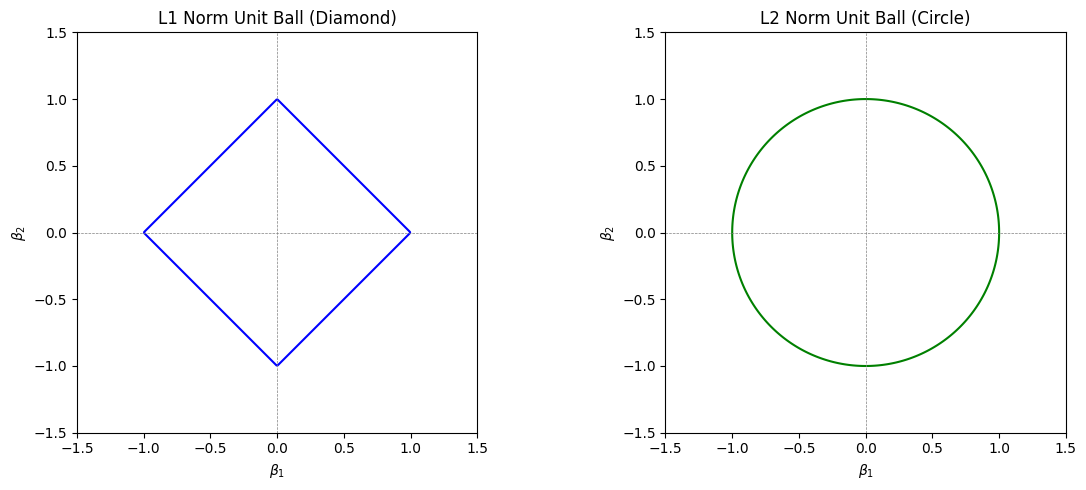

In [2]:
# Create grid
beta1 = np.linspace(-1.5, 1.5, 400)
beta2 = np.linspace(-1.5, 1.5, 400)
B1, B2 = np.meshgrid(beta1, beta2)

# Norms
L1 = np.abs(B1) + np.abs(B2)
L2 = np.sqrt(B1**2 + B2**2)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# L1 Plot
axs[0].contour(B1, B2, L1, levels=[1], colors='blue')
axs[0].set_title('L1 Norm Unit Ball (Diamond)')
axs[0].set_xlabel(r'$\beta_1$')
axs[0].set_ylabel(r'$\beta_2$')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=0.5)
axs[0].axvline(0, color='gray', linestyle='--', linewidth=0.5)
axs[0].set_aspect('equal')

# L2 Plot
axs[1].contour(B1, B2, L2, levels=[1], colors='green')
axs[1].set_title('L2 Norm Unit Ball (Circle)')
axs[1].set_xlabel(r'$\beta_1$')
axs[1].set_ylabel(r'$\beta_2$')
axs[1].axhline(0, color='gray', linestyle='--', linewidth=0.5)
axs[1].axvline(0, color='gray', linestyle='--', linewidth=0.5)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


<img src="PHOTO-2025-05-04-23-17-41.jpg" width="900" height="400" style="margin-left: 40px;">

- The $L_1$ penalty has **sharp corners** in its constraint region (a diamond shape in 2D).  
  → Solutions often land on the axes, setting some coefficients to zero.
- The $L_2$ penalty has a **round constraint region** (a circle in 2D).  
  → Solutions tend to be small, but not exactly zero.

### Key difference:
- **Lasso** → feature selection (sparsity)  
- **Ridge** → coefficient shrinkage (dense, non-zero weights)

---


### 1.2.3 Real Example: Lasso Produces Sparse Coefficients

We now show a simple example using the diabetes dataset.

We'll fit a Lasso model and observe that many coefficients are exactly zero — a clear sign of sparsity.


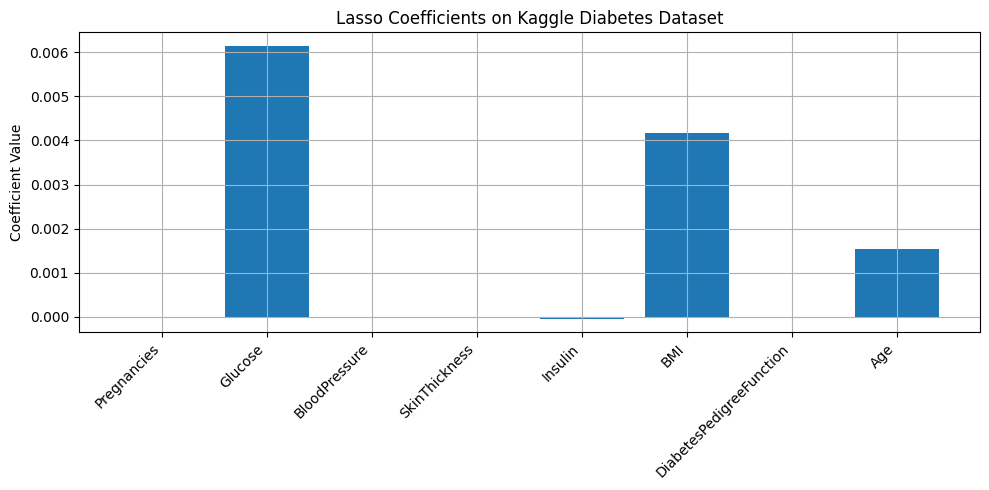

In [3]:
# Load data
path_to_dataset = save_kaggle_data("Diabetes")
df = pd.read_csv(path_to_dataset)

# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Fit Lasso model (this is still regression, even though y is 0/1 — for demonstration)
lasso = Lasso(alpha=0.5)
lasso.fit(X, y)

# Get feature names
feature_names = X.columns.tolist()

# Create DataFrame of coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso.coef_
})

# Plot
plt.figure(figsize=(10, 5))
plt.bar(feature_names, lasso.coef_)
plt.xticks(rotation=45, ha='right')
plt.title("Lasso Coefficients on Kaggle Diabetes Dataset")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.2.4 Weighted Lasso

Weighted Lasso modifies the standard Lasso by assigning **individual penalty weights** to each feature:

$$
\arg\min_{\boldsymbol{\beta} \in \mathbb{R}^p} \left\{ \frac{1}{2n} \sum_{i=1}^n \left( y_i - \beta_0 - \mathbf{x}_i^\top \boldsymbol{\beta} \right)^2 + \lambda \sum_{j=1}^p w_j |\beta_j| \right\}
$$

  - $ w_j $: penalty factor for feature $ j $  
  - Larger $ w_j $ → more penalized → the corresponding coefficient $ {\beta}_j $ must show a stronger relationship with the target to be retained.
  - Smaller $ w_j $ → less penalized → easier for $ {\beta}_j $ to remain nonzero even with a modest connection to the target.

In this way, features with lower weights are favored, but ultimately selection depends on their explanatory power. A feature with a high weight can still be selected if it has a strong predictive relationship with the response.

---

### 1.2.5 Classification with Lasso

While Lasso is traditionally used for regression, it can also be adapted for classification tasks by combining it with **logistic regression**. <br/>
In our setting, we used **L1-penalized logistic regression**, also known as **Logistic Lasso**.

The objective function becomes:

$$
\arg\min_{\boldsymbol{\beta} \in \mathbb{R}^p} \left\{ -\frac{1}{n} \sum_{i=1}^n \left[ y_i \log \hat{p}_i + (1 - y_i) \log (1 - \hat{p}_i) \right] + \lambda \sum_{j=1}^p w_j |\beta_j| \right\}
$$

Where:

- $ \hat{p}_i = \frac{1}{1 + \exp(-\mathbf{x}_i^\top \boldsymbol{\beta})} $: predicted probability of the positive class  
- $ w_j $: penalty weight for feature $ j $ (as shown in 1.2.4)  
- $ \lambda $: regularization parameter controlling sparsity

## 1.3 Illustrative Example: Lasso Path

A common way to visualize how Lasso shrinks coefficients is to look at the **Lasso path**: it shows each coefficient’s value as we vary the regularization parameter $ \alpha $.


---

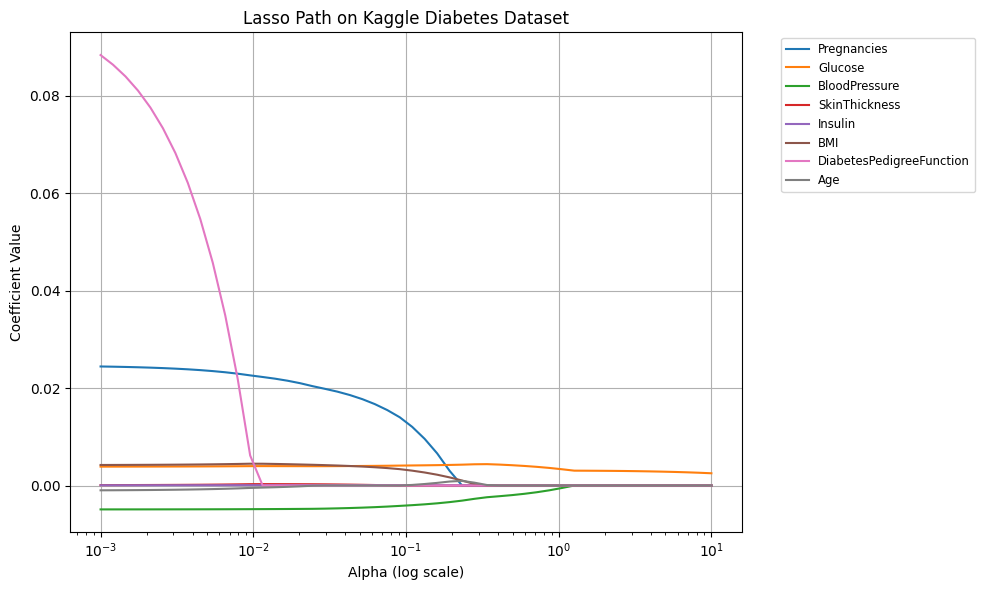

In [4]:
# Compute the Lasso path
alphas, coefs, _ = lasso_path(X.values, y.values, alphas=np.logspace(-3, 1, 50))

# Plot the Lasso path
plt.figure(figsize=(10, 6))
for i, coef in enumerate(coefs):
    plt.plot(alphas, coef, label=feature_names[i])

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Path on Kaggle Diabetes Dataset')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


### 1.3.1 Interpretation of the Lasso Path

- **X-Axis (log-scale $ \alpha $)**: As $ \alpha $ increases (stronger regularization), coefficients shrink toward zero.  
- **Y-Axis (coefficient values)**: Each line represents one feature’s coefficient. Notice how some lines hit zero for higher $ \alpha $, indicating those features drop out of the model.  
- **Feature Selection**: We typically select the “best” $ \alpha $ using a technique like cross-validation, giving us a sparse, more interpretable model.

---


# 2. The LLM-Lasso Method: Core Idea and Reasoning

The paper proposes a new method called LLM-Lasso, which enhances traditional feature selection by combining:

- Lasso regression – a widely used method for selecting features based only on training data

- Large Language Models (LLMs) – which encode domain knowledge based on vast textual information


## 2.1 Why Improve Lasso?

Standard Lasso selects features based only on statistical signals in the training data.

But in many real-world applications, like biomedicine, we often have **external knowledge** about which features (e.g., genes) are likely to be important.

So the paper asks:

> Can we improve Lasso by incorporating external domain knowledge — and do it systematically, using LLMs?

LLM-Lasso proposes to guide feature selection by using an LLM to estimate feature importance — without requiring access to the training data.


## 2.2 Overview

### 2.2.1 How LLM-Lasso Works

LLM-Lasso integrates LLM-driven knowledge with Weighted Lasso. Here's how it works with an example:



1. Define the task 

   - They used the myeloid cell leukemia (MCL) vs. diffuse large B-cell lymphoma (DLBCL) task from the Lymphoma
   dataset.
   </br> In the Lymphoma dataset, the MCL vs. DLBCL task is a binary classification problem.

      DLBCL (Diffuse Large B-Cell Lymphoma):
      -  A type of lymph node cancer.
      -  Starts in B cells, a kind of white blood cell.
      -  Usually shows up as lumps (tumors) in the neck, armpit, or belly.
      -  Can grow quickly but is often treatable.

      MCL (Myeloid Cell Leukemia)
      -  A blood cancer.
      -  Starts in the bone marrow (where blood is made).
      -  Affects myeloid cells, which are early blood cells.
      -  Cancer cells mostly show up in the blood.

      The goal is to predict whether a sample is MCL or DLBCL based on gene expression data.
   </br>It’s important because they require different treatments, and gene profiling improves diagnosis.

       Of the 1592 gene features, they selected the 800 most relevant based on presence in documents retrieved
   from the OMIM (Online Mendelian Inheritance in Man) knowledge base. Then, they replaced those genes
   with random base64 strings, ensuring via OMIM that the strings are not real gene names.b

<img src="gene_example.png" width="550" height="300" style="margin-left: 40px;">

2. Provide the LLM with:
   -  A task description
   - A list of features (e.g., gene names)

   <img src="task_description.png" width="550" height="500">
3. The LLM returns an importance score for each feature

   <img src="model_output.png" width="550" height="200">
4. These scores are converted into penalty weights for a weighted Lasso:
   - High importance → low penalty → easier for $ {\beta}_j $ to remain nonzero and be retained.
   - Low importance → high penalty → the corresponding coefficient $ {\beta}_j $ must show a stronger relationship with the target to be retained.
5. The Lasso model is trained on real data using these custom weights
6. Cross-validation is used to decide how much to trust the LLM's scores

   To ensure robust evaluation of model performance, k-fold cross-validation was used:
   - The dataset is divided into k equal parts.   
   - For each iteration, one part is held out as the test set while the rest are used for training.
   - This process is repeated k times, and the results are averaged to reduce variance and avoid overfitting.

----

### 2.2.2 But LLMs Can Hallucinate

Language models sometimes make things up — a problem known as hallucination. This is especially risky in scientific or medical contexts.

In the example we saw above, even though both genes, Z8ED and PC6LOW are fake, the LLM hallucinates justification for their relevance to the task.

To solve this, the authors use RAG: Retrieval-Augmented Generation.

<u> What is RAG? </u> <br/>
RAG improves the reliability of LLM output by providing it with relevant, factual information retrieved from a knowledge base (like OMIM, a biomedical database) before it generates a response.

How RAG works in LLM-Lasso:
1. Retrieval: A retriever searches for relevant documents based on the task and features
2. Augmentation: These documents are included in the LLM’s prompt
3. Generation: The LLM then generates output using both its internal knowledge and the retrieved evidence

<img src="rag.png" width="700" height="300" style="margin-left: 40px;">

<u> What does RAG help with? </u> <br/>

While RAG does not eliminate hallucinations, it can steer the model toward more grounded and contextually anchored outputs. <br/>
In our case, by providing real biomedical evidence before generating relevance scores, RAG increases the factual alignment of the LLM’s judgments, even though the final output may still require critical validation.

----

### 2.2.3 Putting it all together

<img src="full_model.png" width="900" height="400" style="margin-left: 40px;">


----

### 2.2.4 Prompting Strategy

The way we ask the LLM matters — this is called **prompting**.

Each prompt includes:
- A task description
- A list of feature names
- Instructions for scoring feature relevance

The authors use:
- **Zero-shot prompting**: for large-scale experiments (no examples, just instructions)
- **Few-shot prompting**: for small-scale tasks (adds a few examples)
- **Chain-of-Thought prompting**: asks the LLM to explain its reasoning step-by-step

When RAG is used, the prompt also includes retrieved documents to reduce hallucination.


### Prompt Example:

Using your best general knowledge, provide the most accurate and relevant answer to the question:

Question: 

**Context**: We wish to build a machine learning model that can accurately predict whether a patient has diabetes (target variable), given several diagnostic measurements. The selected individuals in the cohort are female patients of Pima Indian heritage who are at least 21 years old. We measured a total of 8 clinical features (e.g., blood pressure, insulin). Prior to training the model, we first want to identify a subset of the 8 features that are most clinically important for reliable prediction of the target variable.

**Task**: Provide penalty factors for each of the features. These penalty factors should be integers between 2 and 5 (inclusive), where:
- 2 indicates a feature strongly associated with the target variable (i.e., it should be penalized the least by Lasso).
- 5 indicates a feature with minimal relevance to the target variable (i.e., it should be penalized the most by Lasso).

Base these penalty factors on general feature relevance related to the target variable. Do not state that it is impossible to determine exact factors without further data; instead, provide your best estimate from domain knowledge about each feature’s importance in predicting this target.

**Instructions**:
1. You will receive a list of features: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age.
2. For each feature, produce an integer penalty factor from 2 to 5.
3. List the features and their penalty factors in the exact same order they appear in the list.
4. For each penalty factor, provide a brief statement of how you arrived at that score or why the feature is more or less relevant to the target variable.


**Your Response**:

Must contain one entry per feature, each entry including:
- The feature name.
- The penalty factor.
- A succinct reasoning for that factor.
Do not include disclaimers about lacking full data; rely on your domain knowledge.


Here is an example output:

**Year of Birth**: 5
Reasoning: The year in which a defendant was born is not directly relevant to the likelihood of recidivism, and incorporating such information for model training may introduce unwanted biases. Therefore, the score is 5.


The list of features is Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age.

---

# 3. Pros and Cons

### 3.1  ✅ Pros
- Injects domain knowledge into feature selection
- Scalable: works with thousands of features
- Improves performance in biomedical tasks
- RAG reduces hallucination
- Cross-validation adjusts trust in LLM output

### 3.2  ❌ Cons
- LLMs can still hallucinate or misjudge feature relevance
- Harder to interpret than standard Lasso
- Sensitive to prompt quality and document retrieval
- Requires access to powerful (often commercial) LLMs
- May not always outperform traditional Lasso in data-rich settings

# 4. Real Word Examples

## Pima Indians Diabetes Dataset (1988)

This dataset originates from the National Institute of Diabetes and Digestive and Kidney Diseases. It includes clinical diagnostic measures for predicting diabetes onset among female patients of Pima Indian heritage, aged 21 and above.

### Dataset Characteristics:

- Number of Instances: $768$
- Number of Attributes: $9$ (8 features and 1 target variable)
- Target Variable: Binary classification ($0$ for non-diabetic, $1$ for diabetic)

### Attributes:

1. **Number of times pregnant** (integer)
2. **Plasma glucose concentration** (mg/dL, after a 2-hour oral glucose tolerance test)
3. **Diastolic blood pressure** (mm Hg)
4. **Triceps skinfold thickness** (mm)
5. **2-hour serum insulin** ($\mu\text{U/ml}$)
6. **Body mass index** ($\text{BMI} = \frac{\text{weight in kg}}{(\text{height in m})^2}$)
7. **Diabetes pedigree function** (a function that scores likelihood of diabetes based on family history)
8. **Age** (years)
9. **Outcome**: Class variable ($0$ or $1$)

### Source:

Originally obtained from the National Institute of Diabetes and Digestive and Kidney Diseases, available in popular repositories such as the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes).


In [5]:
X, y, feat_names, _ = load_kaggle_data("Diabetes")
X = pd.DataFrame(X, columns=feat_names)
y = pd.Series(y)
save_train_test_splits(X, y, "data/splits/diabetes", balanced=True, n_splits=10, seed=42)

Feature names saved to: small_scale/data/Diabetes_feature_names.pkl


In [6]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0


In [7]:
y.value_counts()/len(X)

0    0.651042
1    0.348958
Name: count, dtype: float64

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
dtypes: float64(8)
memory usage: 48.1 KB


## Baseline For Feature Selection

### 1. [Mutual Information Estimation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) ($\text{mi}$)

Mutual information evaluates the dependency or shared information between each feature $X_i$ and the target variable $y$. Features with high mutual information scores are considered highly informative regarding the target.

Mutual Information is defined as:

$I(X_i; Y) = \int_{X_i}\int_{Y} p(x,y)\log\frac{p(x,y)}{p(x)p(y)}\,dx\,dy$

This formula explicitly depends on the joint density $ p(x,y) $ and marginal densities $ p(x) $ and $ p(y) $.

In real-world datasets, these distributions are typically unknown. Instead, we have finite samples, not exact distributions.


**Estimation using k-Nearest Neighbors (k-NN)**

Sklearn uses a method based on k-nearest neighbors (k-NN) to estimate the mutual information. The core idea behind using k-NN for Mutual Information estimation is:

> *Samples that are close in input space should also be close in the target space if a strong dependency exists.*

**Key Idea:**

Consider each point individually:

1. Find its $ k $-th nearest neighbor in the joint space (feature and target together).

2. Measure the distances between points in the joint space and separately in the feature and target spaces.

3. Compare these distances to estimate the density around each point:
    - If knowing the feature significantly reduces uncertainty about the target, the points that are neighbors in the feature space should also be close in the target space.

By aggregating these distances/densities across all points, you obtain an estimate of how strongly each feature and the target are related, which corresponds directly to the mutual information.


---

### 2. Recursive Feature Elimination ($\text{rfe}$)
Recursive Feature Elimination iteratively removes the least important features based on model-derived weights or importance scores. The general process is:

- Train a Logistic Regression model on all available features.
- After training, each feature receives a coefficient $\beta_i$, which indicates the feature’s influence on the model's decision boundary. The absolute value of each coefficient indicates the relative importance of the corresponding feature. 
- Remove the least important features iteratively, retraining the model until reaching the desired number of features $ k $.

This approach systematically selects features with the highest predictive performance.

---

### 3. Minimum Redundancy Maximum Relevance ($\text{mrmr}$)
The mRMR method selects features by balancing two criteria:

- **Maximum Relevance**: selecting features with high relevance to the target variable.
- **Minimum Redundancy**: ensuring minimal mutual dependence among the selected features themselves.

Formally, the mRMR selection criterion for a set $ S $ of features is given by:

$\text{mRMR}(S) = \max_{S}\left[\frac{1}{|S|}\sum_{X_i \in S}I(X_i; y) - \frac{1}{|S|^2}\sum_{X_i,X_j \in S}I(X_i;X_j)\right]$

Thus, it identifies an optimal subset of features that collectively provides strong predictive power while avoiding redundancy.

---

### 4. Random Selection ($\text{random}$)
Random selection chooses a subset of $k$ features without considering their relationship with the target variable. This baseline is used primarily to establish a reference point, allowing for comparison of other, more sophisticated methods.

---


In [9]:
x_train, x_test, y_train, y_test = read_train_test_splits("data/splits/diabetes", 10)

In [10]:
run_all_baselines_for_splits(
    x_train, y_train, "data/baselines/diabetes", min=0, max=9, step=1, random_state=12)


 10%|████▍                                       | 1/10 [00:00<00:07,  1.13it/s]

Results saved to data/baselines/diabetes/split0/selected_features.json



 20%|████████▊                                   | 2/10 [00:01<00:06,  1.17it/s]

Results saved to data/baselines/diabetes/split1/selected_features.json



 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.19it/s]

Results saved to data/baselines/diabetes/split2/selected_features.json



 40%|█████████████████▌                          | 4/10 [00:03<00:04,  1.20it/s]

Results saved to data/baselines/diabetes/split3/selected_features.json



 50%|██████████████████████                      | 5/10 [00:04<00:04,  1.22it/s]

Results saved to data/baselines/diabetes/split4/selected_features.json



 60%|██████████████████████████▍                 | 6/10 [00:05<00:03,  1.21it/s]

Results saved to data/baselines/diabetes/split5/selected_features.json



 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.20it/s]

Results saved to data/baselines/diabetes/split6/selected_features.json



 80%|███████████████████████████████████▏        | 8/10 [00:06<00:01,  1.20it/s]

Results saved to data/baselines/diabetes/split7/selected_features.json



 90%|███████████████████████████████████████▌    | 9/10 [00:07<00:00,  1.20it/s]

Results saved to data/baselines/diabetes/split8/selected_features.json



100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]

Results saved to data/baselines/diabetes/split9/selected_features.json
All results saved in data/baselines/diabetes


In [11]:
feature_baseline = read_baseline_splits("data/baselines/diabetes", n_splits=10, n_features=8)

In [12]:
feature_baseline['mi'][0]

['Glucose',
 'Age',
 'BMI',
 'Insulin',
 'SkinThickness',
 'DiabetesPedigreeFunction',
 'Pregnancies',
 'BloodPressure']

In [13]:
feature_baseline['rfe'][0]

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [14]:
feature_baseline['mrmr'][0]

['Glucose',
 'BMI',
 'Age',
 'SkinThickness',
 'DiabetesPedigreeFunction',
 'Pregnancies',
 'Insulin',
 'BloodPressure']

In [15]:
feature_baseline['random'][0]

['Age',
 'BloodPressure',
 'BMI',
 'Insulin',
 'DiabetesPedigreeFunction',
 'Pregnancies',
 'Glucose',
 'SkinThickness']

## Feature Selection With LLM Score

In [16]:
os.environ["OPENAI_API_KEY"] = constants.OPENAI_API

In [17]:
model = LLMQueryWrapperWithMemory(
            llm_type=LLMType.GPT4O,
            llm_name="gpt-4o",
            api_key=constants.OPENAI_API,
            temperature=0,
            top_p=0.9,
            repetition_penalty=0.9
        )

In [18]:
llm_results, top_k_dict = llm_score(
    category="Diabetes",
    feature_names=feat_names,
    prompt_filename="../prompts/llm-select/diabetes_prompt.txt",
    save_dir="data/llm-score/diabetes",
    model=model,
    batch_size=30,
    n_trials=1,
    wipe=True,
    k_min=0,
    k_max=50,
    step=1
)

Total number of features in processing: 8.



Processing trial 1...:   0%|                              | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We wish to build a machine learning model that can accurately predict whether a patient has diabetes (target variable), given several diagnostic measurements. The selected individuals in the cohort are female patients of Pima Indian heritage who are at least 21 years old. We measured a total of 8 clinical features (e.g., blood pressure, insulin). Prior to training the model, we first want to identify a subset of the 8 

Processing trial 1...: 100%|██████████████████████| 1/1 [00:08<00:00,  8.08s/it]

Total number of scores collected: 8.
Trial scores saved to data/llm-score/diabetes/trial_scores_llm_score.json
Top-k feature lists saved to data/llm-score/diabetes/llmselect_selected_features.json


In [19]:
top_k_dict[8]

['Glucose',
 'Insulin',
 'BMI',
 'Pregnancies',
 'DiabetesPedigreeFunction',
 'BloodPressure',
 'Age',
 'SkinThickness']

In [20]:
llm_results = ast.literal_eval(llm_results[0])

In [21]:
for result in llm_results['scores']:
    print('Feature:', result['gene'])
    print('Penalty Factor:', result['penalty_factor'])
    print('Reason:', result['reasoning'])
    print('-------------------------------------------------')
    print()

Feature: Pregnancies
Penalty Factor: 0.6
Reason: Pregnancies can be an important feature as the number of pregnancies is associated with gestational diabetes, which can be a risk factor for developing type 2 diabetes later in life.
-------------------------------------------------

Feature: Glucose
Penalty Factor: 0.9
Reason: Glucose levels are directly related to diabetes, as the disease is characterized by high blood sugar levels. Therefore, this feature is highly important for predicting diabetes.
-------------------------------------------------

Feature: BloodPressure
Penalty Factor: 0.5
Reason: While high blood pressure is a common comorbidity with diabetes, it is not as directly indicative of diabetes as glucose levels, making it moderately important.
-------------------------------------------------

Feature: SkinThickness
Penalty Factor: 0.4
Reason: Skin thickness can be related to body fat distribution, which is a risk factor for diabetes, but it is not as directly indicative

In [22]:
feature_baseline["llm_score"] = [top_k_dict[8]] * 10

## Feature Selection With LLM Lasso Score

In [23]:
llm_lasso_results, all_scores = collect_penalties(
    category="Diabetes",
    feature_names=feat_names,
    prompt_file="../prompts/small_scale_prompts/diabetes_prompt.txt",
    save_dir="data/llm-lasso/diabetes",
    vectorstore=None,
    model=model,
    params=PenaltyCollectionParams(wipe=True),
    omim_api_key=None,
    n_threads=1,
    parallel=False
)

Wiping save directory before starting.
Processing 8 features...


LLM response: trial 1...:   0%|                           | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
You are an expert assistant with access to medical and biological knowledge.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Using your best general knowledge, provide the most accurate and relevant answer to the question:

Question: **Context**: We wish to build a machine learning model that can accurately predict whether a patient has diabetes (target variable), given several diagnostic measurements. The selected individuals in the cohort are female patients of Pima Indian heritage who are at least 21 years old. We measured a total of 8 clinical features (e.g., blood pressure, insulin). Prior to training the model, we first want to identify a subset of the 8 features that are most clinically important for reliable prediction of the target variable

LLM response: trial 1...: 100%|███████████████████| 1/1 [00:13<00:00, 13.77s/it]

Trial scores saved to data/llm-lasso/diabetes/trial_scores_plain.json
Results saved to data/llm-lasso/diabetes/results_plain.txt
Scores saved to data/llm-lasso/diabetes/final_scores_plain.pkl and data/llm-lasso/diabetes/final_scores_plain.txt


In [24]:
llm_lasso_results = ast.literal_eval(llm_lasso_results[0])

In [25]:
for result in llm_lasso_results['scores']:
    print('Feature:', result['gene'])
    print('Penalty Factor:', result['penalty_factor'])
    print('Reason:', result['reasoning'])
    print('-------------------------------------------------')
    print()

Feature: Pregnancies
Penalty Factor: 3.0
Reason: Pregnancies can be associated with gestational diabetes, which is a risk factor for developing type 2 diabetes later in life. However, it is not as directly indicative of diabetes as some other features.
-------------------------------------------------

Feature: Glucose
Penalty Factor: 2.0
Reason: Glucose levels are directly related to diabetes, as the disease is characterized by high blood sugar levels. This feature is crucial for predicting diabetes.
-------------------------------------------------

Feature: BloodPressure
Penalty Factor: 4.0
Reason: While high blood pressure is a common comorbidity with diabetes, it is not as directly indicative of diabetes as glucose levels.
-------------------------------------------------

Feature: SkinThickness
Penalty Factor: 4.0
Reason: Skin thickness is sometimes used as a proxy for body fat, but it is not a direct indicator of diabetes. Its relevance is moderate.
-----------------------------

# Training Models and Parameter Tuning via Cross Validation

### Step 1: Reading The Splitted Data

The dataset is splited into multiple (e.g., 10) train-test subsets (splits):

$
(X_{\text{train}}, y_{\text{train}}), \quad (X_{\text{test}}, y_{\text{test}})
$

- **Training set:** Builds and optimizes the model.
- **Test set:** Measures the model’s ability to generalize to unseen data.

---

### Step 2: Scaling Features

Features are standardized using the mean and standard deviation from the **training set**:

$X_{\text{scaled}} = \frac{X - \mu_{\text{train}}}{\sigma_{\text{train}}}$

This ensures all features contribute equally to the regularization.

---

### Step 3: Defining Penalty Factors

In Lasso regression, penalties encourage simpler models by shrinking feature coefficients towards zero. To integrate prior knowledge (LLM-based scores):

$\text{Penalty Factors} = \left\{1, \frac{1}{\text{importance}}, \frac{1}{\text{importance}^2}, \dots, \frac{1}{\text{importance}^5}\right\}$

Higher "importance" leads to lower penalties, encouraging the selection of important features.

---

### Step 4: Cross-Validation for Selecting Best Penalty Factor and $\lambda$

- Train on all but one fold.
- Validate on the excluded fold.
- Repeat for all folds and average results to find the optimal penalty factor.

---

### Step 5: Selecting the Optimal Penalty Factor and $\lambda$

To choose the optimal penalty factor and $\lambda$, we compare models based on cross-validation errors (CVE):

- We compute how much each model improves compared to a standard baseline.
- The best penalty factor has the greatest cumulative improvement: 
    
    $\text{Best Penalty Factor, $\lambda$} = \arg\max \left(\text{Improvement over Baseline}\right)$

---

### Step 6: Final Model Training

Using the best penalty factor, we fit a final model to the entire training set:

- The model minimizes the loss function with a penalty applied to coefficients:
    
    $\text{Loss}(\beta) + \lambda \sum_{j} \text{PenaltyFactor}_j \cdot |\beta_j|$

- Here, $\lambda$ controls overall penalty strength, chosen through cross-validation.
---

### Step 7: Model Evaluation on Test Data

The model is evaluated on the previously untouched test set, using:

- Test Error: $\frac{1}{N_{\text{test}}} \sum_{i=1}^{N_{\text{test}}} I(\hat{y}_i \neq y_i)$
- AUROC (Area under ROC curve): measures how well a classification model can distinguish between two classes. The ROC curve plots True Positive Rate (TPR) against False Positive Rate (FPR) across all thresholds:

    $\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \quad \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}$


    - AUROC = 1: Perfect classifier.
    - AUROC = 0.5: Random guessing.
    - Higher AUROC indicates better model performance.


---

### Step 8: Baseline Models for Comparison

Baseline models (e.g., logistic or linear regression) using standard-selected features are also evaluated:

- They serve as a reference to measure how much improvement the LLM-Lasso provides.

---

### Step 9: Results Aggregation

Performance metrics are averaged across all splits:

- This average provides a reliable estimate of how well each model generalizes:

    $\text{Average Metric} = \frac{1}{\text{Number of Splits}}\sum_{\text{splits}} \text{Metric}_{\text{split}}$

---

In [26]:
res = run_repeated_llm_lasso_cv(
    x_train_splits=x_train, x_test_splits=x_test,
    y_train_splits=y_train, y_test_splits=y_test,
    scores={'plain': np.array(all_scores)},
    feature_baseline=feature_baseline,
    n_splits=10,
    folds_cv=10,
    score_type = PenaltyType.PF,
    lambda_min_ratio=0.001,
    n_threads=8,
)

Processing split 0 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 1 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 2 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 3 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 4 of 10
	Running model: plain
Running pf_type Lasso
Running

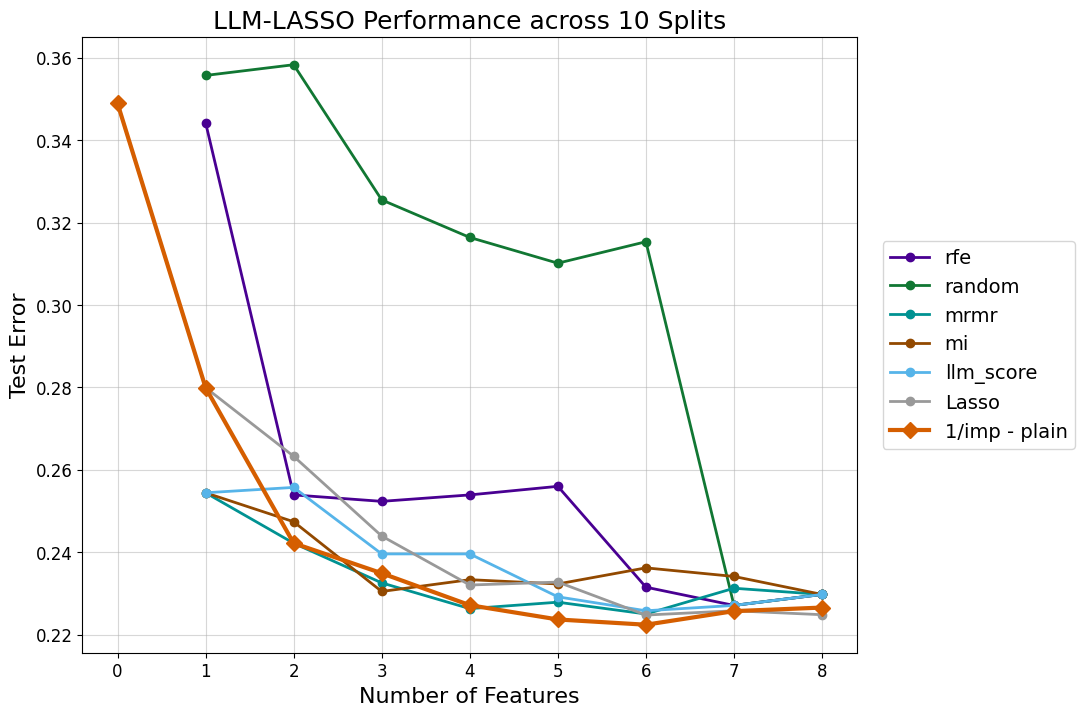

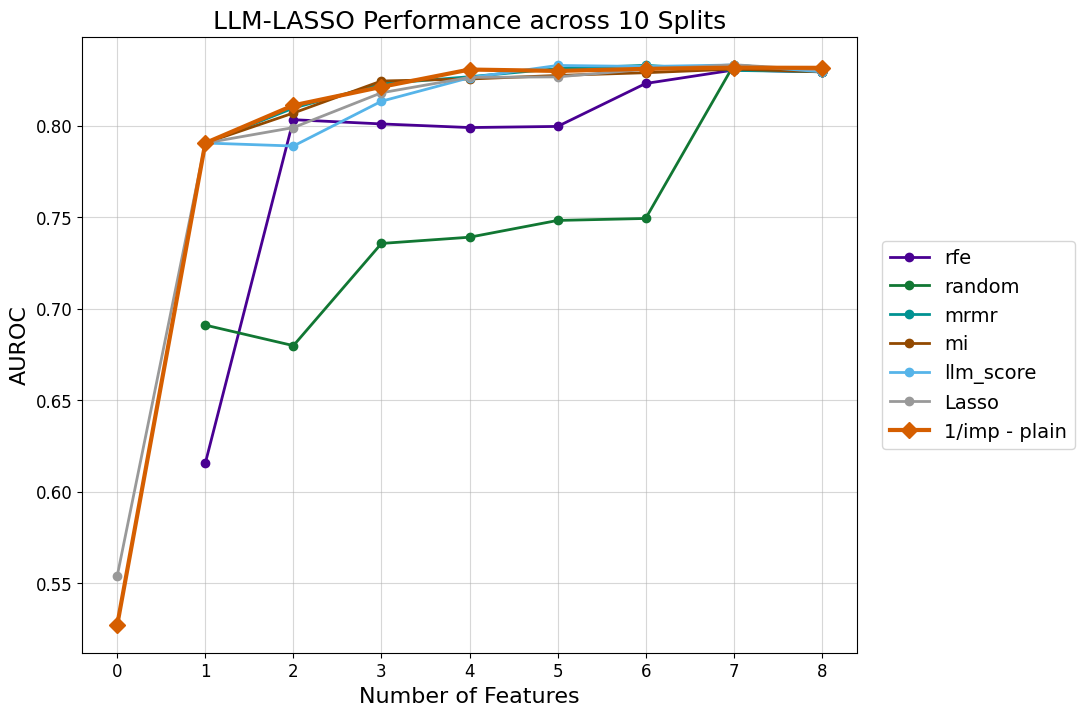

In [27]:
plot_llm_lasso_result(
    res,
    bolded_methods=["1/imp - plain"],
    plot_error_bars=False
)

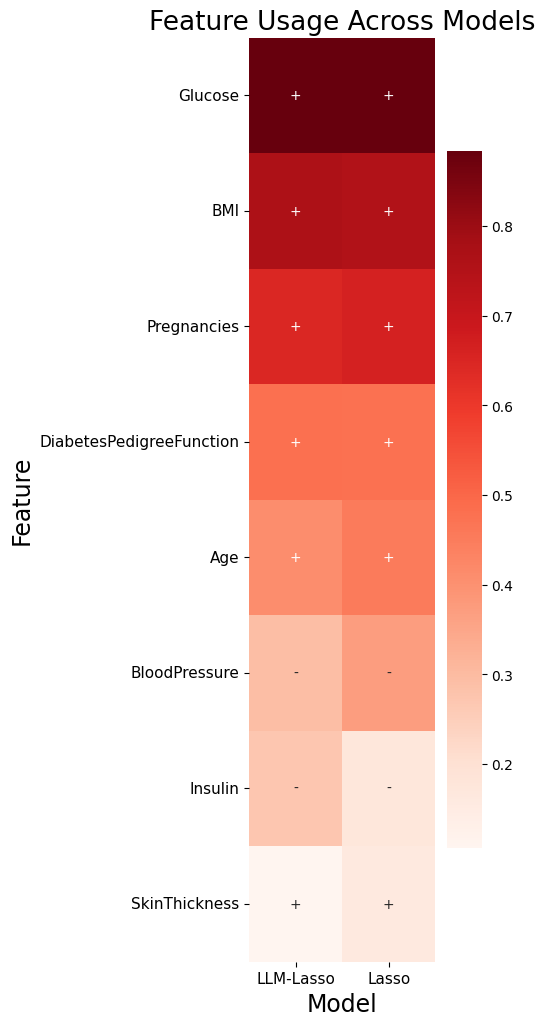

In [28]:
plot_heatmap(
    res,
    method_models=["1/imp - plain", "Lasso"], # these are from the method_model column of the dataframe
    labels=["LLM-Lasso", "Lasso"], # this is how each method_model will be labeled on the plot
    feature_names=x_train[0].columns,
    sort_by="LLM-Lasso"
)

# Other Small-Scale Datasets 

## Classification Datasets

### 1. **Glioma Grading Clinical and Mutation Features (2022)**
- **Source:** [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Glioma+Grading+Clinical+and+Mutation+Features)
- **Size:** `(839 rows, 23 columns)`
- **Features:** Clinical and genetic mutation data from glioma (brain cancer) patients. Includes patient demographics, clinical metrics (e.g., age, gender, race), and genomic mutation information.
- **Target:** Classification task to predict glioma tumor grading (malignancy or severity).

---

### 2. **Bank Marketing Dataset (2012)**
- **Source:** [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- **Size:** Approximately `(45,211 rows, 17 columns)` originally, though your code preprocesses and subsets it.
- **Features:** Demographic and financial features such as age, job, marital status, education level, default status, housing loan, personal loan, contact communication type, and month of last contact.
- **Target:** Predict if a client will subscribe (`yes` or `no`) to a term deposit.

---

## Regression Datasets

### 1. **Spotify Streams Dataset (2024)**
- **Source:** [Kaggle (Most Streamed Spotify Songs 2024)](https://www.kaggle.com/datasets/nelgiriyewithana/most-streamed-spotify-songs-2024)
- **Size:** `(4600 rows, 28 columns)` (training or main dataset), `(565 rows, 22 columns)` a separate subset or test set.
- **Features:** Track metadata, quantitative features including track scores, artist rankings, numerical popularity indicators, duration, tempo, loudness, key, and other streaming metrics.
- **Target:** Predict the numerical count of Spotify streams.
---

### 2. **Wine Quality Dataset (2009)**
- **Source:** [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)
- **Size:** `(6,497 rows, 11 columns)` total from combined red and white wine samples (the dataset provided by UCI actually consists of two subsets: red wine (`1599`) and white wine (`4898`), totalling `6497` samples).
- **Features:** Physicochemical properties of wines, including volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, and alcohol.
- **Target:** Predict wine quality. Usually, this dataset is used both for regression (predicting numerical quality scores) or classification (high vs. low quality).

---

<img src="small_scale_res.png" width="750" height="450" style="margin-left: 40px;">


# Large-Scale Dataset and RAG Usage

## The Lipoma datasets
The datasets used in the large-scale experiments has not been published and are currently confidential. The datasets are outlined in the given table where $n$, $p$ denotes resp. sample size and number of features. 

<img src="Screenshot 2025-04-29 at 11.38.50.png" width="500" height="400">



### Why to use RAG
<img src="Screenshot 2025-04-29 at 11.39.48.png" width="800" height="500">


### The pipeline of getting penalty factors for a pre-specified list of genes, with their names supplied is:
1. Scraping down information from OMIM with OMIM API into JSON files.
2. Preprocessing the scraped OMIM JSON files and Populating a Chroma-based vectorstore using the OMIM knowledge base.
3. Collecting penalty factors with a specified user prompt and an LLM model.

### The Large-Scale Tests Results

<img src="Screenshot 2025-04-29 at 11.38.35.png" width="600" height="300">

<img src="Screenshot 2025-04-29 at 12.06.47.png" >

Also, they tested the effectivness of using different models in the framework - 

<img src="llm_lasso_error.png" width="600" height="300" style="margin-left: 80px;">


## Communities and Crime Dataset (UCI)

The **Communities and Crime** dataset from the UCI Machine Learning Repository provides data on socio-economic, law enforcement, and crime characteristics across various communities in the United States. This dataset is often utilized for regression and exploratory analyses on community-level crime prediction.

### Dataset Overview:

* **Number of Instances:** 1994
* **Number of Attributes:** 128
* **Target Variable:** Violent crime rate (per 100K population)

The features (attributes) can be grouped into several key categories:

### Attribute Groups and Examples:

1. **Community Demographics**

   * Percentage of population aged 12–21
   * Percentage of population aged 65 and over
   * Percentage of African-American, Hispanic, or Asian residents

2. **Socioeconomic Indicators**

   * Median family income
   * Per capita income
   * Percentage of people below poverty level
   * Percentage unemployed

3. **Education Factors**

   * Percentage without high school diploma
   * Percentage with a college degree
   * High school dropout rate

4. **Family Structure**

   * Percentage of single-parent households
   * Divorce rate

5. **Housing and Urbanization**

   * Percentage of housing occupied
   * Percentage of vacant houses
   * Median house value

6. **Law Enforcement Information**

   * Number of police officers per capita
   * Police funding per capita

7. **Crime Information (Target Variable)**

   * Violent crimes per 100K population


### Data Source and Access:

* The dataset is publicly available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/communities+and+crime).

---

## Applying the Process:
- The goal is to predict high probability to violance 


In [29]:
X2, y2, feat_names2, _ = load_uci_data("Communities")
X2 = pd.DataFrame(X2, columns=feat_names2)
X2.drop(columns=['State'], inplace=True)
X2.fillna(0, inplace=True)
y2 = [1 if val > 5 else 0 for val in y2]
y2 = pd.Series(y2)
feat_names2 = feat_names2[1:]
save_train_test_splits(X2, y2, "data/splits/communities", balanced=True, n_splits=10, seed=42)

Processed feature names and descriptions saved to: small_scale/data/Communities_feature_names.json


In [30]:
x_train2, x_test2, y_train2, y_test2 = read_train_test_splits("data/splits/communities", 10)

In [31]:
run_all_baselines_for_splits(
    x_train2, y_train2, "data/baselines/communities", min=0, max=31, step=5, random_state=12)


 10%|████▍                                       | 1/10 [00:55<08:18, 55.42s/it]

Results saved to data/baselines/communities/split0/selected_features.json



 20%|████████▊                                   | 2/10 [01:53<07:33, 56.75s/it]

Results saved to data/baselines/communities/split1/selected_features.json



 30%|█████████████▏                              | 3/10 [02:48<06:33, 56.25s/it]

Results saved to data/baselines/communities/split2/selected_features.json



 40%|█████████████████▌                          | 4/10 [03:43<05:34, 55.68s/it]

Results saved to data/baselines/communities/split3/selected_features.json



 50%|██████████████████████                      | 5/10 [04:39<04:38, 55.67s/it]

Results saved to data/baselines/communities/split4/selected_features.json



 60%|██████████████████████████▍                 | 6/10 [05:33<03:41, 55.32s/it]

Results saved to data/baselines/communities/split5/selected_features.json



 70%|██████████████████████████████▊             | 7/10 [06:29<02:46, 55.40s/it]

Results saved to data/baselines/communities/split6/selected_features.json



 80%|███████████████████████████████████▏        | 8/10 [07:24<01:50, 55.25s/it]

Results saved to data/baselines/communities/split7/selected_features.json



 90%|███████████████████████████████████████▌    | 9/10 [08:18<00:55, 55.02s/it]

Results saved to data/baselines/communities/split8/selected_features.json



100%|███████████████████████████████████████████| 10/10 [09:13<00:00, 55.32s/it]

Results saved to data/baselines/communities/split9/selected_features.json
All results saved in data/baselines/communities


In [32]:
feature_baseline2 = read_baseline_splits("data/baselines/communities", n_splits=10, n_features=30)

In [33]:
llm_results2, top_k_dict2 = llm_score(
    category="Diabetes",
    feature_names=feat_names2,
    prompt_filename="../prompts/llm-select/communities_prompt.txt",
    save_dir="data/llm-score/communities",
    model=model,
    batch_size=30,
    n_trials=2,
    wipe=True,
    k_min=0,
    k_max=30,
    step=5
)

Total number of features in processing: 124.



Processing trial 1...:   0%|                              | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad


Processing trial 1...:  20%|████▍                 | 1/5 [00:29<01:59, 29.81s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad


Processing trial 1...:  40%|████████▊             | 2/5 [00:51<01:15, 25.29s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad


Processing trial 1...:  60%|█████████████▏        | 3/5 [01:19<00:52, 26.42s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad


Processing trial 1...:  80%|█████████████████▌    | 4/5 [01:50<00:28, 28.30s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad

Processing trial 2...:   0%|                              | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad


Processing trial 2...:  20%|████▍                 | 1/5 [00:27<01:48, 27.23s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad


Processing trial 2...:  40%|████████▊             | 2/5 [00:51<01:15, 25.29s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad


Processing trial 2...:  60%|█████████████▏        | 3/5 [01:13<00:48, 24.07s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad


Processing trial 2...:  80%|█████████████████▌    | 4/5 [01:38<00:24, 24.48s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
For each feature input by the user, your task is to provide a feature importance score (between 0 and 1; larger value indicates greater importance) for predicting whether an individual will subscribe to a term deposit and a reasoning behind how the importance score was assigned.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broad

Processing trial 2...: 100%|██████████████████████| 5/5 [01:45<00:00, 21.09s/it]

Total number of scores collected: 124.
Trial scores saved to data/llm-score/communities/trial_scores_llm_score.json
Top-k feature lists saved to data/llm-score/communities/llmselect_selected_features.json


In [35]:
feature_baseline2["llm_score"] = [top_k_dict2[30]] * 10

In [36]:
llm_lasso_results2, all_scores2 = collect_penalties(
    category="communities",
    feature_names=feat_names2,
    prompt_file="../prompts/communities_prompt.txt",
    save_dir="data/llm-lasso/communities",
    vectorstore=None,
    model=model,
    params=PenaltyCollectionParams(wipe=True),
    omim_api_key=None,
    n_threads=4,
    parallel=False
)

Wiping save directory before starting.
Processing 124 features...


LLM response: trial 1...:   0%|                           | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
You are an expert assistant with access to medical and biological knowledge.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Using your best general knowledge, provide the most accurate and relevant answer to the question:

Question: Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broader set of features, but we've focused on selecting the most relevant subset for effectively pr


LLM response: trial 1...:  20%|███▊               | 1/5 [00:25<01:41, 25.44s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
You are an expert assistant with access to medical and biological knowledge.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Using your best general knowledge, provide the most accurate and relevant answer to the question:

Question: Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broader set of features, but we've focused on selecting the most relevant subset for effectively pr


LLM response: trial 1...:  40%|███████▌           | 2/5 [00:45<01:07, 22.50s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
You are an expert assistant with access to medical and biological knowledge.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Using your best general knowledge, provide the most accurate and relevant answer to the question:

Question: Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broader set of features, but we've focused on selecting the most relevant subset for effectively pr


LLM response: trial 1...:  60%|███████████▍       | 3/5 [01:09<00:45, 22.82s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
You are an expert assistant with access to medical and biological knowledge.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Using your best general knowledge, provide the most accurate and relevant answer to the question:

Question: Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broader set of features, but we've focused on selecting the most relevant subset for effectively pr


LLM response: trial 1...:  80%|███████████████▏   | 4/5 [01:38<00:25, 25.25s/it]

----------------------------------------------------------------
System Message:
----------------------------------------------------------------
You are an expert assistant with access to medical and biological knowledge.

----------------------------------------------------------------
The Prompt:
----------------------------------------------------------------
Using your best general knowledge, provide the most accurate and relevant answer to the question:

Question: Context: We aim to develop a machine learning model capable of accurately predicting whether a community will have high crime rates (target variable), based on various socio-economic and law enforcement-related features. The dataset includes diverse communities across the United States, encompassing demographic details, economic indicators, law enforcement statistics, and social factors. Initially, the dataset contained a broader set of features, but we've focused on selecting the most relevant subset for effectively pr

LLM response: trial 1...: 100%|███████████████████| 5/5 [01:49<00:00, 21.82s/it]

Trial scores saved to data/llm-lasso/communities/trial_scores_plain.json
Results saved to data/llm-lasso/communities/results_plain.txt
Scores saved to data/llm-lasso/communities/final_scores_plain.pkl and data/llm-lasso/communities/final_scores_plain.txt


In [37]:
res2 = run_repeated_llm_lasso_cv(
    x_train_splits=x_train2, x_test_splits=x_test2,
    y_train_splits=y_train2, y_test_splits=y_test2,
    scores={'plain': np.array(all_scores2)},
    feature_baseline=feature_baseline2,
    n_splits=10,
    folds_cv=10,
    score_type = PenaltyType.PF,
    lambda_min_ratio=0.001,
    n_threads=8,
)

Processing split 0 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 1 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 2 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines


/Users/guyvered/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing split 3 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 4 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 5 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 6 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 7 of 10
	Running model: plain
Running pf_type Lasso
Running

/Users/guyvered/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/guyvered/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

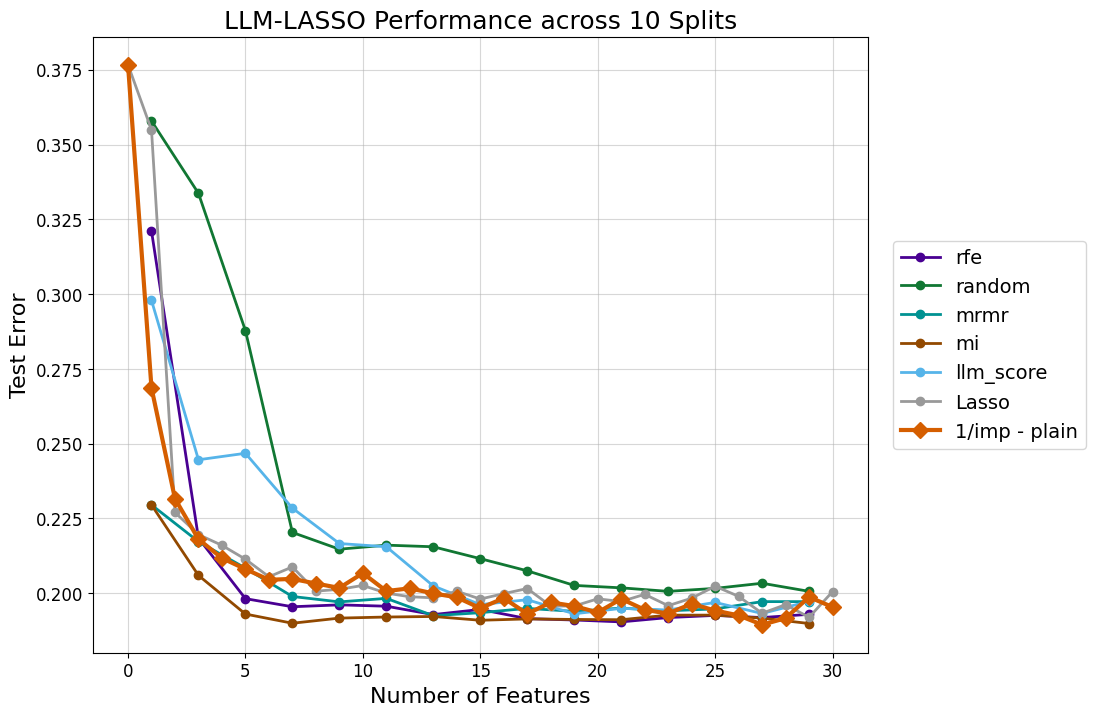

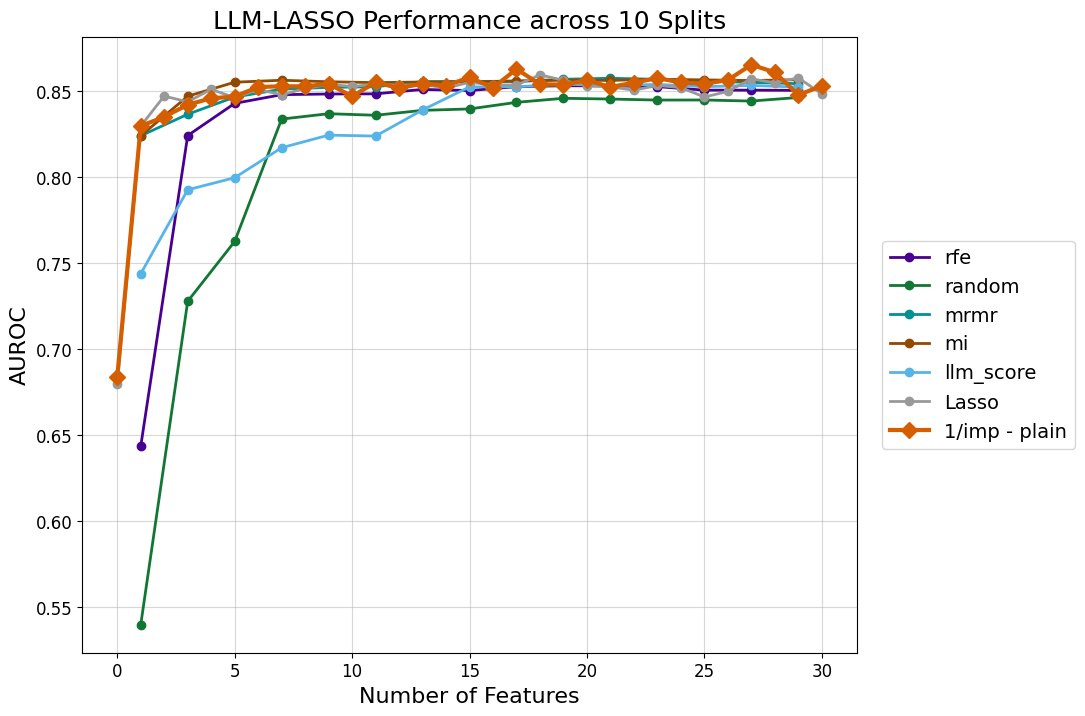

In [38]:
plot_llm_lasso_result(
    res2[res2.n_features <= 30],
    bolded_methods=["1/imp - plain"],
    plot_error_bars=False
)

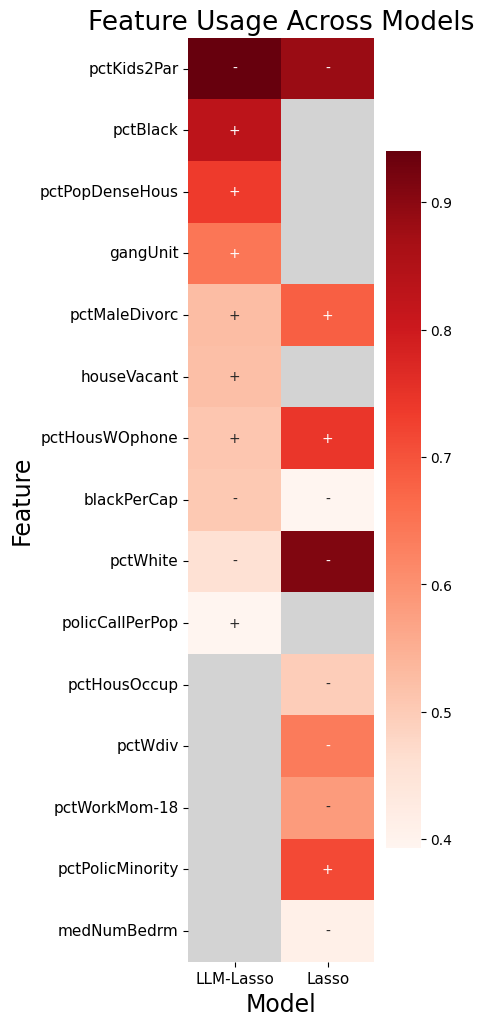

In [39]:
plot_heatmap(
    res2[res2.n_features <= 30],
    method_models=["1/imp - plain", "Lasso"], # these are from the method_model column of the dataframe
    labels=["LLM-Lasso", "Lasso"], # this is how each method_model will be labeled on the plot
    feature_names=x_train2[0].columns,
    sort_by="LLM-Lasso"
)